In [26]:

#import package
import functools

import gymnasium
import numpy as np
from gymnasium.spaces import Discrete, Tuple
from gymnasium.spaces import Box

from pettingzoo import ParallelEnv
from pettingzoo.utils import agent_selector, wrappers
import pandas as pd
import pyNetLogo
import numpy as np
from itertools import count
import random
import math

import argparse
import os
from typing import List, Optional, Tuple

import gym
import numpy as np
import pettingzoo.butterfly.pistonball_v6 as pistonball_v6
import torch
torch.manual_seed(42)
from torch.utils.tensorboard import SummaryWriter



import matplotlib.pyplot as plt

import gym
from gym import spaces
from gym.utils import seeding

In [2]:
# set model

net_model = pyNetLogo.NetLogoLink(gui = True, netlogo_home = 'D:\\Program Files\\NetLogo 6.1.0',netlogo_version = '6.1',jvm_home = 'D:\\Program Files\\NetLogo 6.1.0\\runtime\\bin\\server\\jvm.dll')

net_model.load_model('C:\\Users\\Owner\\OneDrive - Delft University of Technology\\homework\\graduation_work\\netlogo model\\layout_2_allocation.nlogo')


In [199]:
# set order for each parking space
def reset_state():
    global info_vehicle
    global num_last_vehicles
    global car_total_number
    global space_number
    global plabel
    red_values = []
    net_model.command('setup')
    net_model.command('ask patches [set order plabel]')
    car_total_number = int(net_model.report('car-total-number'))
    space_number = car_total_number
    order = net_model.patch_report('order')
    plabel = net_model.patch_report('plabel')
    
    net_model.command('set strategy 0')
    allocation_1 = pd.read_excel('C:\\Users\\Owner\\OneDrive - Delft University of Technology\\homework\\graduation_work\\netlogo model\\allocation_2.xlsx', sheet_name='strategy_1',header = None)
    allocation_1.columns = range(1,20)
    allocation_1.index = range(12, 0, -1)
    mask = plabel.iloc[0:-1,1:20] == 1
    plabel_sub = plabel.iloc[0:-1,1:20][mask]
    allo_1_sub = allocation_1.iloc[0:,0:][mask]
    plabel_sub[plabel_sub == 1] = allo_1_sub[allo_1_sub != None]
    plabel.iloc[0:-1,1:20][mask] = plabel_sub
    
    order = plabel + 1
    # order is from 1  to the car_total_number
    net_model.patch_set('order',order)
    net_model.command('ask patches with [order = 0] [set order -1]')
    net_model.command('ask patches [set plabel (plabel - 2)]')
    net_model.patch_report('order')
    net_model.command('ask patches with [pcolor = grey][set plabel -1]')
    
    
    
 
    
    
    cate = plabel.copy()        
    route_1 = pd.read_excel('C:\\Users\\Owner\\OneDrive - Delft University of Technology\\homework\\graduation_work\\netlogo model\\allocation_2.xlsx', sheet_name='route_2',header = None)
    route_1.columns = range(1,20)
    route_1.index = range(12, 0, -1)
    mask = cate.iloc[0:-1,1:20] != 0
    cate_sub = cate.iloc[0:-1,1:20][mask]
    route_1_sub = route_1.iloc[0:,0:][mask]
    cate_sub[cate_sub == 1] = route_1_sub[route_1_sub != None]
    cate.iloc[0:-1,1:20][mask] = route_1_sub


    route_2 = pd.read_excel('C:\\Users\\Owner\\OneDrive - Delft University of Technology\\homework\\graduation_work\\netlogo model\\allocation_2.xlsx', sheet_name='route_1',header = None)
    route_2.columns = range(1,20)
    route_2.index = range(12, 0, -1)
    mask_2 = (plabel.iloc[0:-1,1:20].isin(red_values))
#         print('mask_2',mask_2)
    cate_sub_2 = cate.iloc[0:-1,1:20][mask_2]
#     print('cate_sub_2',cate_sub_2)
    route_2_sub = route_2.iloc[0:,0:][mask_2]
    #cate_sub_2[cate_sub_2 != None] = route_2_sub[route_2_sub != None]
    cate.iloc[0:-1,1:20][mask_2] = route_2_sub 
#         print('route_2_sub',route_2_sub)
        
#         print('cate',cate)
        
        
     
        
        
        
        
        
        
    
    
    net_model.patch_set('cate-route',cate)
#     net_model.patch_set('plabel',plabel)
    
    #info about the parking situation about vehicles
    who = np.array(range(int(car_total_number)))
    parked_or_not = np.zeros(int(car_total_number))
    time_spent = np.zeros(int(car_total_number))
    rewarded = np.zeros(int(car_total_number))
    info_vehicle = np.array([who, parked_or_not, time_spent, rewarded]).T
    info_vehicle = pd.DataFrame(info_vehicle, columns = ['who', 'parked_or_not', 'time_spent','rewarded'])
    num_last_vehicles = 0
    
    
reset_state()
route_2 = pd.read_excel('C:\\Users\\Owner\\OneDrive - Delft University of Technology\\homework\\graduation_work\\netlogo model\\allocation_2.xlsx', sheet_name='route_1',header = None)
route_2.columns = range(1,20)
route_2.index = range(12, 0, -1)
def set_route_2(who):
    global route_2
    global plabel
    cate = plabel.copy()
    red_values = [int(who)]
    mask_2 = (plabel.iloc[0:-1,1:20].isin(red_values))
#         print('mask_2',mask_2)
    cate_sub_2 = cate.iloc[0:-1,1:20][mask_2]
#     print('cate_sub_2',cate_sub_2)
    route_2_sub = route_2.iloc[0:,0:][mask_2]
    #cate_sub_2[cate_sub_2 != None] = route_2_sub[route_2_sub != None]
    cate.iloc[0:-1,1:20][mask_2] = route_2_sub

In [201]:
# def get_environment(netlogo):
#     num_now = np.array([int(net_model.report('count turtles'))])
#     # from 0 to 48
                
#     return num_now
def get_environment(netlogo):
    patches = np.zeros(int(car_total_number))
    if net_model.report('count turtles') == car_total_number:
        patches = np.ones(int(car_total_number))
    else:
        patches_num = net_model.report('count patches with [plabel > 0]')
        if patches_num > 0:
            patch_label = set(net_model.report('[order] of patches with [plabel > 0]'))
            for item in patch_label:
                patches[int(item - 1)] = 1
    return patches
def get_reward(): # different for each agent, same if they have the same objective
    # if 5 more vehicles are parked or all vehicles are parked, get a reward.
    global info_vehicle
    global num_last_vehicles
    N = 1
    reward = 0
    parked_vehicle_num = net_model.report('count turtles with [parked? = true]')
    if parked_vehicle_num > 0:
        parked_vehicle = list(net_model.report('[who] of turtles with [parked? = true]')) 
        #np.arra
        for i in parked_vehicle:
            row_index = info_vehicle.index[info_vehicle['who'] == i][0]
            info_vehicle.at[row_index, 'parked_or_not'] = 1
    
    info_vehicle.loc[info_vehicle['parked_or_not'] == 0, 'time_spent'] += 1
    if (parked_vehicle_num >= (num_last_vehicles + N))  or parked_vehicle_num == car_total_number:
        
            
        # reward should be the total time spend with these newly parked vehicles
        # be scaled in [0,100] in most cases, using linear function 
        avg_time_spent = info_vehicle.loc[(info_vehicle['rewarded'] == 0) & (info_vehicle['parked_or_not'] == 1), 'time_spent'].sum() / (parked_vehicle_num - num_last_vehicles)
        info_vehicle.loc[(info_vehicle['rewarded'] == 0) & (info_vehicle['parked_or_not'] == 1), 'rewarded'] = 1
        # scale the reward
#         print(info_vehicle)

        reward = (- avg_time_spent + 100) / (100 - 35) * 100
        num_last_vehicles = parked_vehicle_num
    return reward

def perform_action(action, unava):
    'action is the order for the parking space'
    'if the action choose this parking space, then it will have a plabel'
    'the same with the car entering'
    'order from 1 to the parking_space number'
    'but action may start from 0, so maybe should modify it later'
    'action : 76* 2'
    'in layout 2, action is an array [order,0/1], 0 means park on the right(red value), 1 means park on the left'
    allocate_order = int(action//2)
    direction = action % 2
    if len(unava) == car_total_number:
        return
    num_turtles = net_model.report('count turtles')
    if num_turtles > 0:
        
#         unava_plabel = set(net_model.report("[plabel] of patches with [pcolor = gray]"))
#         who = int(num_turtles - 1)
        who = max(set(net_model.report('[plabel] of patches with [pcolor = grey]'))) + 1
#         if who not in set(net_model.report('[plabel] of patches with [pcolor = grey]')):
        if who < car_total_number:
            s = 'ask patches with [order = '+str(int(allocate_order + 1))+'][set plabel '+str(int(who))+']'
    #         if (who not in unava_plabel):
            net_model.command(s)
            if direction == 0:
                net_model.command('set red_values lput '+ str(who) +' red_values')
                set_route_2(int(who))

def observe(): # all agents share the same observation
    envir = get_environment(net_model).reshape(car_total_number, 1)

    return envir



obs = observe() # observe is the same
print(obs.shape)

(76, 1)


In [270]:
class MyCustomEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        self.action_space = spaces.Discrete(space_number * 2)

#         self.observation_space = spaces.Discrete(space_number+1)
        self.observation_space = spaces.Box(low=0, high=1, shape=obs.shape, dtype=np.uint8)
        self.seed()
        self.state = None
        self.num_iter = 0
        self.reward = 0
        self.unava = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed],

    def reset(self):
        reset_state()
        self.state = observe()
        self.num_iter = 0
        self.reward = 0
        self.info = {'training': self.reward}
        self.action_space = spaces.Discrete(space_number * 2)
        self.unava = []
        net_model.command('go')
        com = 'set red_values [] '
        net_model.command(com)

        return self.state
    def step(self, action):
        # perform action
        # action is from 0
        # order is action + 1
        max_iter = 500
#         while self.action_ava.contains(action) == false:
#             self.step()
        who = net_model.report('count turtles')
        unava_num = net_model.report('count patches with [plabel > 0]')
        if unava_num > 0:
            self.unava = list(map(int,set(net_model.report("[order] of patches with [plabel >= 0]"))))
        if unava_num == car_total_number:
            action = None
            while net_model.report('count turtles with [parked = true]') < car_total_number:
                net_model.command('go')
                self.num_iter += 1
                if self.num_iter > max_iter:
                    break

            
        else:
            assert self.action_space.contains(action)
#             action= get_action_mask(action)
            
            perform_action(action, self.unava)
            self.unava = list(map(int,set(net_model.report("[order] of patches with [plabel >= 0]"))))
            net_model.command('go')
            self.num_iter += 1
            while net_model.report('count turtles') < who + 1 and who != car_total_number:
                net_model.command('go')
                self.num_iter += 1
                if self.num_iter > max_iter:
                    break

        #reward
        self.reward = get_reward()

        #state
        self.state = observe()
        terminated = (net_model.report('count turtles with [parked? = true]') == car_total_number)
        truncated = (self.num_iter >= max_iter)
                    
        done = (terminated or truncated)
        if done:
            self.info = {'final_reward': self.reward}
        else:
            self.info = {'training': self.reward}

        return self.state, self.reward, terminated, truncated, self.info
    def close(self):
        net_model.kill_workspace()      


In [273]:
env = MyCustomEnv()
env.reset()

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [274]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Complete
tensor([2095.3845, 2372.3076, 1480.0000, 1281.5385, 1612.3077, 1720.0000,
        2223.0769, 1455.3846, 2260.0000, 2244.6155, 2035.3846, 1649.2307,
        1826.1538, 2720.0000, 1710.7693, 2304.6155, 2643.0769, 2466.1538,
        1866.1538, 2138.4614, 1884.6154, 1993.8462, 2326.1538, 1883.0769,
        1750.7693, 2306.1538, 2203.0769, 1729.2307, 2778.4614, 2381.5386,
        1949.2307, 2269.2307, 1946.1538, 1883.0769, 2084.6155, 2344.6155,
        2238.4614, 2092.3076, 1976.9231, 2087.6924, 2363.0769, 1855.3846,
        1541.5385, 2118.4614, 1910.7693, 2129.2307, 1832.3077, 1207.6923,
        1740.0000, 2192.3076, 2078.4614, 2504.6155, 1940.0000, 1893.8462,
        2792.3076, 2323.0769, 1983.0769, 2187.6924, 2027.6923, 2295.3845,
        2490.7693, 1849.2307, 2469.2307, 2298.4614, 2100.0000, 1696.9231,
        1835.3846, 2160.0000, 1896.9231, 1684.6154, 2361.5386, 1950.7693,
        2432.3076, 2478.4614, 2147.6924, 1760.0000, 1689.2307, 1720.0000,
        2381.5386, 2224.6155,

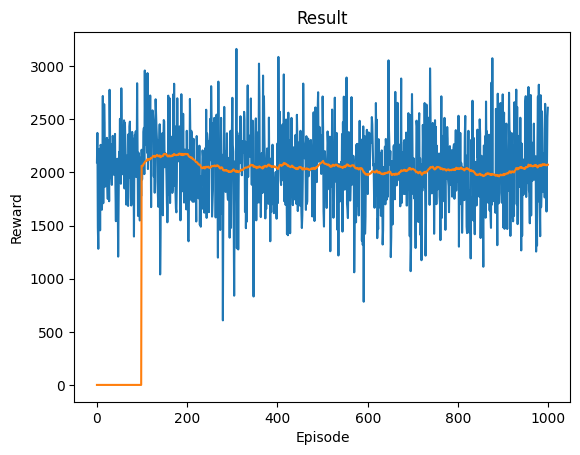

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [287]:
# reply memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
# Q-network

import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.reshape(-1,car_total_number)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)




# training
# Hyperparameters and utilities


# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 2000
TAU = 0.005
LR = 0.01

# Get number of actions from gym action space
n_actions = env.action_space.n
print(n_actions)
# Get the number of state observations
state = env.reset()
n_observations = len(state)
print('n_observations',n_observations)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state,env):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if len(env.unava) == car_total_number:
        return torch.tensor(env.action_space.sample()).view(1,1)
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            for i in torch.sort(policy_net(state),descending = True)[1][0]:
                if int(i // 2 + 1) not in env.unava:
                    return i.view(1,1)
                

#             return policy_net(state).max(1)[1].view(1, 1)
                
    else:
        action = env.action_space.sample()
        while int(action // 2 + 1) in env.unava:
            action = env.action_space.sample()
        return torch.tensor(action).view(1,1)


total_reward = []
duration_loss = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(total_reward, dtype=torch.float)
#     d_loss = torch.tensor(duration_loss.copy(), dtype=torch.float)
    print(durations_t)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
#     plt.legend()
    plt.plot(durations_t.numpy())
#     plt.plot(d_loss.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


# training loop

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return loss

if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 1000

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    rew_eps = 0
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state,env)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model()
        

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        rew_eps += float(reward)     
        if done:
            total_reward.append(rew_eps)
            duration_loss.append(float(loss))
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()